# TODO
Test in another folder that the zip send will work

# Installation
## Cytomine:
Using pip, you can do it with these two lines:
~~~
$ curl -s https://packagecloud.io/install/repositories/cytomine-uliege/Cytomine-python-client/script.python.sh | bash
$ pip install cytomine-python-client
~~~


# Import


In [3]:
from cytomine import Cytomine
from cytomine.models import ProjectCollection, ImageInstanceCollection, AnnotationCollection
import getpass
import shapely
from shapely import wkt
from shapely.affinity import affine_transform
import cv2                             # OpenCV
from imgTools import display, multiDisplay
import os, sys
import logging
import segment_detector as sd
import numpy as np
from metrics_lines import metricNaive, metricFalseNeg, metricFalsePos, metricTot

# Image database
The evaluation requires the database with all images. If you want to run the evaluation, please provide us the path to the folder(s) containing the images with the code bellow.

In [2]:
resp = input("Do you want to run the evaluation? (If not, what follows will not be needed) [y, n] : ")
if resp == 'n':
    EVALUATE = False
    PATH_FOLDER_IMG = None
else:
    EVALUATE = True
    print("Could you please provide us the path to the folder?")
    PATH_FOLDER_IMG = []
    while True:
        print("\nThe current list of folders is : ")
        for path in PATH_FOLDER_IMG:
            print(f'\t- {path}')
        resp = input("Do you want to add a new folder? [y, n] : ")
        if resp == 'n':
            break
        else:
            resp = input("What is the new path? : ")
            PATH_FOLDER_IMG.append(resp)

if EVALUATE:
    print("\n\nThe final list of folders is : ")
    for path in PATH_FOLDER_IMG:
        print(f'\t- {path}')

Do you want to run the evaluation? (If not, what follows will not be needed) [y, n] : n


# Cytomine connection
This is used to get the line annotations.

In [3]:
EVALUATE = True

In [4]:
if EVALUATE:
    host = 'https://learn.cytomine.be'
    public_key = getpass.getpass('Public key of cytomine account : ')   # u can get it on your account
    private_key = getpass.getpass('Private key of cytomine account : ') # u can get it on your account

    CONN = Cytomine.connect(host, public_key, private_key, verbose=logging.ERROR)
    # Check https://docs.python.org/3.6/library/logging.html#logging-levels  to see other verbose level
    print(CONN.current_user)

Public key of cytomine account : ········
Private key of cytomine account : ········
[2019-12-14 19:03:41,814][ERROR] [GET] [currentuser] CURRENT USER - 0 : None | 401 Unauthorized ()
False


# Evaluation of line detection
## Metrics description
To evaluate the line detection previously implemented, it was required to choose a metric. The metrics  for segment detection were designed from scratch as no satisfying metrics were found during our research.

<br><br>

**From annoted line parameters to annoted images**

The images of the annoted line is obtained by drawing the line with a width of 3 pixels on a black image of the same size. The line width of 3 was chosen arbitrarily to take into consideration the degree of precision of the annotation which is not perfect.

<br><br>

**Positive and negative classification**

Let's define some important terms : 
$$
\begin{array}{ll}
      \text{line pixel } &= \text{ pixel classified as a line by the annotation}\\
      \text{not a line pixel } &= \text{ pixel classified as not a line by the annotation}\\
      \text{positive pixel } &= \text{ pixel classified as a line by the dectection}\\
      \text{negative pixel } &= \text{ pixel classified as not a line by the dectection}\\
      \text{true positive pixel } &= \text{ line pixel classified as a line by the dectection}\\
      \text{false positive pixel } &= \text{ not a line pixel classified as a line by the dectection}\\
      \text{true negative pixel } &= \text{ not a line pixel classified as not a line by the dectection}\\
      \text{false negative pixel } &= \text{ line pixel classified as not a line by the dectection}\\
\end{array}
$$

<br><br>

**Naive metric**

The first implemented metric is :
$$\text{metric naive } = \frac{p_c}{p_t} \quad \text{with} \left\{
    \begin{array}{l}
      p_c = \text{ number of pixels well classified}\\
      p_t = \text{ total number of pixels}\\
    \end{array}
\right.$$

The metric give a value of the accuracy in the interval [0,1].

As the name indicates, it is a very naive metric as the number of line pixels are so low that an image with no lines detected will give a good result.

<br><br>

**False negative metric**

The second implemented metric is based on penalization of the false negative pixels :
$$\text{metric false neg. } = min\big(1, \frac{1}{a_{neg}}\frac{p_{tp}}{p_l}\big) \quad \text{with} \left\{
    \begin{array}{l}
      p_{tp} = \text{ number of true positive pixels }\\
      p_{l} = \text{ total number of line pixels}\\
      a_{neg} = \text{ acceptable accuracy for false negative}\\
    \end{array}
\right.$$
The acceptable accuracy is arbitrarly fixed at $a_{neg} = 0.8$. As the annotation are not perfectly made due to human error, a perfect accuracy should not be expected with this metric either. Thus, using this accepetable metric will simply give the best accuracy score for $\frac{p_{tp}}{p_l}\geq 0.8 $.

The metric give a value of the accuracy in the interval [0,1].

This metrics has the disadvantage of giving a perfect score for a method detecting each pixels as a line. Thus, a new metric is introduced : the false positive metric.

<br><br>

**False positive metric**

This third metric is based on penalization of the false positive pixels:
$$\text{metric false pos. } = min\big(1, \frac{1}{a_{pos}}(max(0, 1-\frac{3\;p_{fp}}{p_{nl}}))\big) \quad \text{with} \left\{
    \begin{array}{l}
      p_{fp} = \text{ number of false positive pixels }\\
      p_{nl} = \text{ total number of not a line pixels}\\
      a_{pos} = \text{ acceptable accuracy for false positive}\\
    \end{array}
\right.$$
As $p_{nl}$ is usually a high number, this metric can easily give a high score, thus the acceptable accuracy for false positive is fixed to $a_{pos} = 1$ and the number of false positive is multiplied by 3 to have a higher penalization.

The metric give a value of the accuracy in the interval [0,1].

This metric has the opposite disadvantage of the false negative metric, a method detecting no line on the image will always give a perfect score. 

<br><br>

**Total metric**

As the two previous metric had opposite disadvantage, it is easy to convince ourself that combining the two will obtain a new metric robust to those two cases.

$$\text{metric tot. } = w_1\;\text{metric false neg. } + w_2\;\text{metric false pos. }\quad \text{with} \left\{
    \begin{array}{l}
      w_1 \in [0,1]\\
      w_2 \in [0,1]\\
      w_1 + w_2 = 1\\
    \end{array}
\right.$$

The metric give a value of the accuracy in the interval [0,1]. The weight were both set to $w_1 = w_2 = 0.5$ such that both the method detecting lines on all pixels and the detecting no lines would have a score of about $0.5$.

Note that the false positive metric is very simple and can easily give high score, thus changing it to a better one would give more representative results of the detection method accuracy.


## Example line metrics

In this example, the metric for one image is given for 4 cases with the corresponding scores:

$
\left.
    \begin{array}{ll}
      \quad\text{- the actual detection } &: m_{tot} \simeq 0.7\\
      \quad\text{- all pixels as not a line } &: m_{tot} \simeq 0.5\\
      \quad\text{- all pixels as line} &: m_{tot} \simeq 0.5\\
      \quad\text{- all pixels randomly detected as line or not } &: m_{tot} \simeq 0.3\\
    \end{array}
\right.$

The score are as expected much better for the actual detection than the other ones. It can be noticed that the false positive metric is quite harsh. It gave a low score to the actual detection and a score of 0 to the randomly pixels. This will cause the total metric to only give good score for image with high number of true positive and very low number of false positive.

In [5]:
import metrics_line_example

metrics_line_example.evaluate(CONN)        

Using cytomine with user : {conn.current_user}
[2019-12-14 19:03:41,862][ERROR] [GET] [project collection] 0 objects | 401 Unauthorized ()


TypeError: 'bool' object is not iterable

## Evaluation of the database
Using the metrics described above to evaluate our detection method on the full database will give the corresponding scores:


$
\left.
    \begin{array}{ll}
      \quad\text{- metric naive } &: m_{nai} = 0.945\\
      \quad\text{- metric false neg. } &: m_{neg} = 0.725\\
      \quad\text{- metric false pos. } &: m_{pos} = 0.860\\
      \quad\text{- metric total } &: m_{tot} = 0.793\\
    \end{array}
\right.$

The false negative metric has a good accuracy, however, it still has room for improvement. The false positive metric is very high which will improve the total metric accuracy. As explained earlier, the false positive metric is simple and easily give high score, even though it is not that good to the human eye. However it was difficult to find another metric to penalize correctly the false positive pixels.

In general, the evaluation indicates that our detection method has good accuracy but could have been better.

In [ ]:
import evaluateSegDetec

if EVALUATE:
    resp = input("Do you want to evaluate the line detector of part1? \nThis will takes 2-3 minutes for the full database. [y, n] : ")
    if resp == 'y':
        evaluateSegDetec.evaluate(PATH_FOLDER_IMG, CONN)

# Evaluation of ellipse detection
## Metrics description
### Distance between two ellipses
It is assumed that the ellipses are defined by 5 parameters:
- Xc : the vert. coord of the center of the ellipse
- Yc : the horiz. coord of the center of the ellipse
- theta : the angle of the main axis
- a  : half the length of main axis
- b  : half the length of sub axis

~~~
elps1 = [Xc1, Yc1, theta1, a1, b1]
elps2 = [Xc2, Yc2, theta2, a2, b2]
W = [Wx, Wy, Wt, Wa, Wb]
dist = Wx * abs(Xc1-Xc2) + Wy * abs(Yc1-Yc2) + Wt * min(abs(theta1-theta2), abs(180-abs(theta1-theta2))  + Wa * abs(a1-a2) + Wb * abs(b1-b2)
~~~
The weight W is tuned such that the maximal acceptable error on each parameters will lead to an increase in the distance of 1. Thus if we want an acceptable error of theta of 15 degrees, we fix Wt = 1/15. This way, we can fix the tresh_dist = 5 (see next subsection). This is the maximal acceptable distance between two ellipses. By fixing it at 5, we only need to tune W. The parameters W will depend on the precision expected on the labelled ellipse. 

Note that as a difference of 180 degree in theta correspond to the same angle, 'min(abs(theta1-theta2), abs(180-abs(theta1-theta2))' is used instead of 'abs(theta1-theta2)'.

In practice, the weights used are : $$W = [\frac{1}{2}, \frac{1}{2}, \frac{1}{5}, \frac{1}{3}, \frac{1}{3}]$$

Example : If we assume that the label for the x coord. of the center is has a precision of two pixels in, i.e there is a two pixels difference between the true x coord and the x coord. labelled, then we can put Wx = 1/2.

### Metric on multiple images
Let ground_truth and detected both being a list of list of ellipses, respectivelly being the labeled ellipses for each images and the detected ellipses for each images. The evaluation is done on the following pseudo-code:

~~~
metrics_elps(ground_truth, detected, tresh_dist):
    eval = 0
    for each image:
        gt_elps = ground_truth of the corresponding image
        dt_elps = detected of the corresponding image

        num = 0
        denom = max(len(gt_elps), len(dt_elps))

        dists = np.zeros((len(gt_elps), len(dt_elps)))
        for el in dists:
            el = dist(gt_elps[index1(el)], dt_elps[index2(el)]

        index1_rem = []
        index2_rem = []
        for i in range(min(len(gt_elps), len(dt_elps))):
            el = min(dists) where (not index1(el) in index1_rem) and (not index2(el) in index2_rem)
            index1_rem.append(index1(el))
            index2_rem.append(index2(el))

            num += min(1, tresh_dist/el)

        eval += num/denom
    return eval/num_image
~~~

In other words, the evaluation metric give a value between 0 and 1, 1 being the best accuracy. The evaluation for multiple images is the mean of all image evaluations. For each image, the evaluation of this images is a fraction. Let $$f(x) = min(1, \frac{tresh\_dist}{x}),$$ a function which returns 1 if x < tresh_dist and something < 1 in other cases. The choice of the tresh_dist is done such that a distance lower than it doesn't make sense compared to the precision of the labelling.

The numerator is the sum of function f on the smallest distances between the detected ellipses and the labeled ellipses where each detected and labeled ellipse can only be used once. When the number of detected and labeled ellipses aren't the same, the distance are computed until no pair can be made.

In the other hand, the denominator is the maximum between the number of detected and labeled ellipses. Thus the value can decrease due to two reasons : if the detection detect less or more ellipses than in the ground truth and if the detected ellipses are distant from the labeled ones.


In the special case where there is 0 ellipse in the ground truth the score is 0 if ellipse are detected or 1 if no ellipse are detected.

## Example of evaluation
In the example bellow, the metric for different detection will be displayed. As explained above, the number of ellipse detected will influence the final metric value. To better understand the detection strength and weakness, the metric with or without the penalization for detecting more/less ellipse than existing ellipse will be used.

It is tested on 5 cases:
    - Same parameters with a 180 change in theta
        => metric = 1 for both
    - Two ellipses detected with wrong parameters 
        => it is seen that detecting x times more ellipse than existing ones will divide the score by x (x = 2 here).
    - Detecting an ellipse with parameters in the limit of the acceptable error
        => metric = 1 for both.
    - Detected ellipse close to the ground truth but not exactly it.
    - The ground truth detected but other too 
        => it will give a low score. 

In [2]:
import metrics_elps_example

metrics_elps_example.evaluate()        

SyntaxError: invalid syntax (metrics.py, line 28)

## Evaluation of the classical method on the database
Using the metrics described above to evaluate our detection method on the full database will give the corresponding scores:

- On the eye images with 1 ellipse
$$
\left.
    \begin{array}{ll}
      \quad\text{- metric penalizing } &: m_{p} = 0.36\\
      \quad\text{- metric non penalizing } &: m_{np} = 0.58\\
    \end{array}
\right.$$

- On the eye images with 0 ellipse
$$
\left.
    \begin{array}{ll}
      \quad\text{- metric penalizing } &: m_{p} = 0.21\\
      \quad\text{- metric non penalizing } &: m_{np} = 0.21\\
    \end{array}
\right.$$

In the case of the images with 1 ellipse, the average number of ellipses detected is : $\frac{0.58}{0.36} = 1.61$ which is pretty good. However, in the case of 0 ellipse on the image, only 1 image out of 5 did the algorithm detect no ellipse which isn't that good. Going back to the case of 1 ellipse, the metric non penalizing reach a good accuracy.

Giving our weights, assuming that the error in split equally on the parameters, the ellipse detected will have a distance to the ground truth ellipse of : 
$$\frac{2}{0.6} = 3.33\text{ pixels of Xc}, 3.33\text{ pixels of Yc}, 8.33\text{ degrees of theta},5 \text{ pixels of a},5 \text{ pixels of b}  $$

In conclusion, the classical method has a good accuracy but struggle to detect the exact number of ellipses.

In [6]:
import evaluateElpsClassical

if EVALUATE:
    TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOo = > preprocess
    resp = input("Do you want to evaluate the line detector of part1? \nThis will takes several minutes for the full database. [y, n] : ")
    if resp == 'y':
        evaluateElpsClassical.main(PATH_FOLDER_IMG)

Using TensorFlow backend.


Do you want to evaluate the line detector of part1? 
This will takes several minutes for the full database. [y, n] : y

The folders containing the images are "
['images_database/eyes/noEllipses/full/', 'images_database/eyes/preprocess/']
". Do you want to change them? [y, n] : n
Progress : 0.16% 	 - Value m1 = 0.35 	 m2 = 0.70    

KeyboardInterrupt: 

# Evaluation of bounding box detection
## Metrics description
### Distance between two ebounding box
The metric and distance are the same as for the ellipse. The only differences is that there are only 4 parameters (the coordinates of the bottom left corner and top right corner), the weight are $W = [\frac{1}{2},\frac{1}{2},\frac{1}{2},\frac{1}{2}]$ and the tresh_dist is now equal to 4.

## Example of evaluation
In the example bellow, the metric for different detection will be displayed. As explained above, the number of ellipse detected will influence the final metric value. To better understand the detection strength and weakness, the metric with or without the penalization for detecting more/less ellipse than existing ellipse will be used.

It is tested on 5 cases:
    - Same parameters
        => metric = 1 for both
    - Two boxes detected with wrong parameters 
        => it is seen that detecting x times more box than existing ones will divide the score by x (x = 2 here).
    - Detecting a box with parameters in the limit of the acceptable error
        => metric = 1 for both.
    - Detected box far from the ground truth.
    - The ground truth detected but other too 
        => it will give a low score. 


Start evaluation...


The ground truth ellipse is : 
	Xldc = 50.0, Yldc = 100.0, Xruc = 150.0, Yruc = 50.0.

--------------------------------
The metrics for the ellipse(s) :
	Xldc = 50.0, Yldc = 100.0, Xruc = 150.0, Yruc = 50.0.
Penalizing metric =     1.0
Non penalizing metric = 1.0

--------------------------------
The metrics for the ellipse(s) :
	Xldc = 60.0, Yldc = 80.0, Xruc = 170.0, Yruc = 30.0.
	Xldc = 60.0, Yldc = 120.0, Xruc = 150.0, Yruc = 70.0.
Penalizing metric =     0.1600002719997824
Non penalizing metric = 0.3200005439995648

--------------------------------
The metrics for the ellipse(s) :
	Xldc = 52.0, Yldc = 98.0, Xruc = 148.0, Yruc = 52.0.
Penalizing metric =     1.0
Non penalizing metric = 1.0

--------------------------------
The metrics for the ellipse(s) :
	Xldc = 60.0, Yldc = 130.0, Xruc = 80.0, Yruc = 70.0.
Penalizing metric =     0.12307719289932524
Non penalizing metric = 0.12307719289932524

--------------------------------
The metrics for the ellipse(s) 

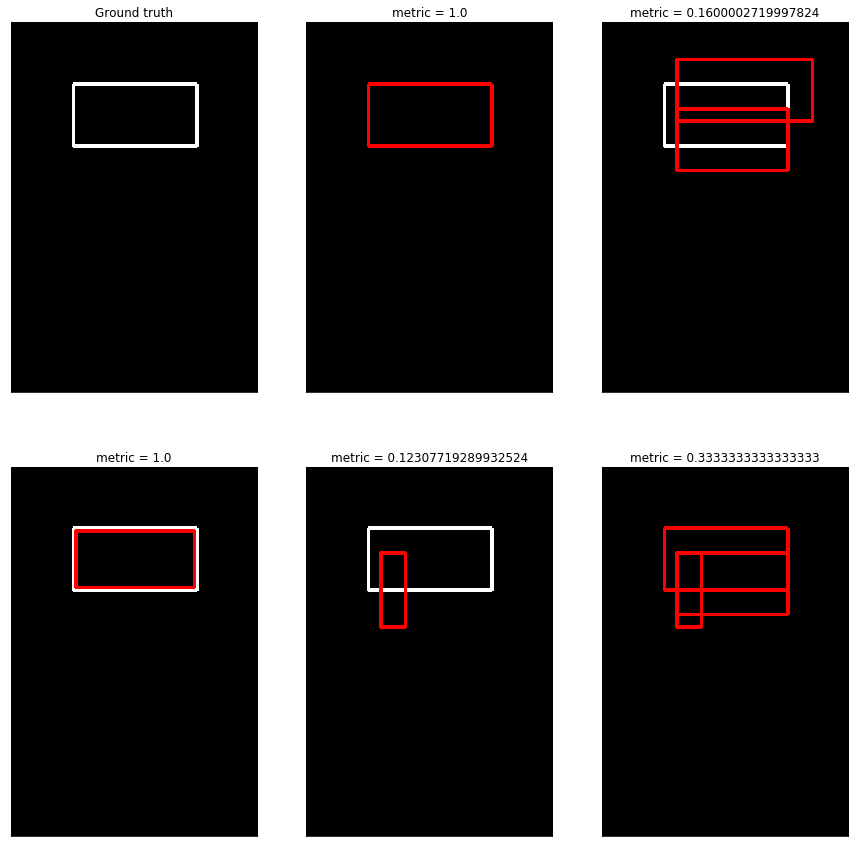

In [4]:
import metrics_box_example

metrics_box_example.evaluate()        